In [1]:
import cv2
import os
import torch 
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchvision import datasets
from torch.utils.data import DataLoader
import random
import numpy as np
import pandas as pd
from torchvision.io import read_image
from skimage import io, transform
from sklearn.preprocessing import MultiLabelBinarizer
import torchvision.models as tmodels

**Multi Label Classification**

Load DataSet

In [2]:
class MultiLabelDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.root_dir = root_dir
        self.annotations = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,self.annotations.iloc[idx, 1])
        image = io.imread(img_name)
        labels = self.annotations.iloc[idx, 2]

        sample = {'image': image, 'labels': labels}

        if self.transform:
            sample['image'] = self.transform(sample['image'])
            
#         print("sample",sample)
        return sample

In [3]:
classes = {'T-Shirt','Trouser','PullOver','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot'}

batch_size=4
label_count=len(classes)



trainset = MultiLabelDataset(csv_file = '/home/dnn4/pythonCodeArea/sayam/train/labels.csv',root_dir = '/home/dnn4/pythonCodeArea/sayam/train/',transform = transforms.Compose([transforms.ToTensor()]))
trainloader = DataLoader(trainset, batch_size=batch_size,shuffle=True, num_workers=10)
testset = MultiLabelDataset(csv_file = '/home/dnn4/pythonCodeArea/sayam/test/labels.csv', root_dir = '/home/dnn4/pythonCodeArea/sayam/test/',transform = transforms.Compose([transforms.ToTensor()]))
testloader = DataLoader(trainset, batch_size=batch_size,shuffle=False, num_workers=10)

In [4]:
img=next(iter(testloader))
img['labels']

['[1, 1, 0, 1, 0, 0, 0, 0, 0, 1]',
 '[1, 0, 1, 1, 1, 0, 0, 0, 0, 0]',
 '[0, 0, 1, 0, 1, 0, 0, 1, 0, 1]',
 '[0, 0, 0, 0, 0, 0, 1, 1, 1, 0]']

Convolution Neural Network

In [5]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        res_state=tmodels.resnet18(pretrained=True)
        self.cnn=nn.Sequential(*list(res_state.children())[:-1])
        self.f3 = nn.Linear(512, 10)

    def forward(self, x):
        x=self.cnn(x)
        x=torch.squeeze(x)
#         print("x.shape",x.shape)
        x = self.f3(x)
        return x

In [6]:
net = Net()
net = net.cuda()

In [7]:
# x=torch.rand(4,1,28,128)

# x=x.repeat(1, 3, 1,1)
# x=x.cuda()
# y=net(x)


Loss Function

In [8]:
criterion = nn.BCEWithLogitsLoss()
optimiser = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

Train the Network

In [9]:
for epoch in range(4):  # Iterations over the dataset
    loss_at_iteration = 0.0
    total=0.0
    correct=0
    x = 0
    y = 0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels= data['image'], data['labels']
        inputs=inputs.repeat(1, 3, 1,1)
#         print('labels',labels)
#         for t in range(len(labels)):
#             labels[t]=list(labels[t])
#         print('labels',labels)
            
        m=torch.zeros([batch_size,label_count])
        for i in range(batch_size):
            for j in range(label_count):
                if labels[i][j]!='[' and labels[i][j]!=']' and labels[i][j]!=',' and labels[i][j]!=' ':
                    m[i][j]=int(labels[i][j]) 
                    
        inputs = inputs.cuda(), 
#         labels = torch.Tensor(labels)
        m = m.cuda()

        # set the parameter gradients to zero
        optimiser.zero_grad()

        # forward backward and optimise
        outputs = net(inputs[0])
        
#         print(type(outputs),type(labels))
        loss = criterion(outputs, m)
        loss.backward()
        optimiser.step()
        
        
        predicted=torch.topk(outputs, 4)
        predicted_indices = predicted[1]        

        total += m.shape[0]*4
        
        multi_hot_GT=torch.zeros([batch_size,label_count]).cuda()
        for i in range(batch_size):
            for p in range(len(predicted_indices[i])):
                multi_hot_GT[i][predicted_indices[i]]=1        
        
#         print("(multi_hot_GT == m1).sum().item()",(multi_hot_GT == m1).sum().item())
        for i in range(batch_size):
            for j in range(label_count):
                if m[i][j]==1 and multi_hot_GT[i][j]==1:
                    correct+=1 
        
        
        #if i % 100 == 99:    # print every 2000th mini-batche
#     print(f'{epoch + 1} epoch loss: {loss_at_iteration.3f} accuracy: {100 * correct // total}')
    print('epoch:', epoch + 1,'loss: ',loss_at_iteration, 'accuracy:', 100 * correct // total)

    loss_at_iteration = 0.0

print('Done')

epoch: 1 loss:  0.0 accuracy: 25.0
epoch: 2 loss:  0.0 accuracy: 25.0
epoch: 3 loss:  0.0 accuracy: 25.0
epoch: 4 loss:  0.0 accuracy: 25.0
Done


In [10]:
type(inputs[0])

torch.Tensor

In [11]:
#To Save The Network
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

Test the Network

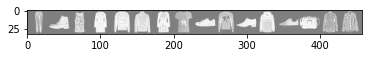

In [12]:
#function to show image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

data_iter = iter(testloader)
images, labels = data_iter.next()['image'] , data_iter.next()['labels']

# print images
imshow(torchvision.utils.make_grid(images))
#print('Ground Truth: ', ' '.join(f'{classes[labels[j][0]]:5s}' for j in range(4)))

In [13]:
#Reload the saved Model
net = Net()
net.load_state_dict(torch.load(PATH))
net = net.cuda()
images, m = images.cuda(), m.cuda()

In [14]:
# outputs = net(images[0])
# _,predicted = torch.sort(outputs,1)
# predicted = predicted[-4:]

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    correct = 0
    total = 0
    for data in testloader:
        images, labels = data['image'],data['labels']
        m1=torch.zeros([batch_size,label_count])
        for i in range(batch_size):
            for j in range(label_count):
                if labels[i][j]!='[' and labels[i][j]!=']' and labels[i][j]!=',' and labels[i][j]!=' ':
                    m1[i][j]=int(labels[i][j]) 
                    
        images, m1 = images.cuda(), m1.cuda()
        
        
#         print("images.shape",images.shape)
        # outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        
        
        
#         _, predicted = torch.sort(outputs.data, 1)
        predicted=torch.topk(outputs, 4)
        predicted_indices = predicted[1]
        
        multi_hot_GT=torch.zeros([batch_size,label_count]).cuda()
        for i in range(batch_size):
            for p in range(len(predicted_indices[i])):
                multi_hot_GT[i][predicted_indices[i]]=1

#         print("m1",m1)#,predicted)
#         print("multi_hot_GT",multi_hot_GT)
        
        total += m1.shape[0]*4
#         print("(multi_hot_GT == m1).sum().item()",(multi_hot_GT == m1).sum().item())
        for i in range(batch_size):
            for j in range(label_count):
                if m1[i][j]==1 and multi_hot_GT[i][j]==1:
                    correct+=1
        
        
#         correct += (multi_hot_GT == m1).sum().item()
        
        

print(f'Accuracy on the 10000 test images: {100 * correct // total} %')

RuntimeError: Given groups=1, weight of size [64, 3, 7, 7], expected input[4, 1, 28, 112] to have 3 channels, but got 1 channels instead

In [ ]:
def multi_hot_func(multihot_batch):
    print(multihot_batch.shape)
#     multihot_batch = torch.tensor([[0,1,0,1], [0,0,0,1], [0,0,1,1]])
    #multihot_batch = torch.tensor([[0,1,0,1], [0,0,0,1], [0,0,1,1], [0,0,0,1]])
    vnon = (multihot_batch == torch.tensor(1)).nonzero(as_tuple=False).cuda()
    v0 = vnon[:,0].cuda()
    v1 = vnon[:,1].cuda()

    # 0-based index -> 1-based index
    split_ind = ((torch.roll(v0, -1, 0) - v0) == 1).nonzero(as_tuple=False)[:,0] + 1
    split_ind = split_ind.cuda()
    print(split_ind.shape)
    # the first index is excatly the split size of the first split
    # the other splits(apart from the last one) can be obtained by this
    split_size = torch.cat([split_ind[0].view(1),(torch.roll(split_ind, -1, 0) - split_ind)[:-1]])
    # add the final split size
    split_size=split_size.cuda()
    
    final_size = torch.tensor([torch.numel(v1) - torch.sum(split_size)])
    
    final_size=final_size.cuda()
    split_size = torch.cat([split_size, final_size])
    
    return torch.split(v1, split_size.tolist())

# print()

In [ ]:
multihot_batch = torch.tensor([[0,1,0,1], [0,0,0,1], [0,0,1,1]])
multihot_batch.shape